In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json

import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import lax

from jaxcmr.helpers import import_from_string
from jaxcmr.math import normalize_magnitude
from jaxcmr.state_analysis import instance_memory_heatmap, matrix_heatmap

## Setup

In [3]:
model_path = "jaxcmr.models_repfr.weird_positional_cmr"
fit_path = "projects/thesis/fits/LohnasKahana2014_PositionScaleWeirdCMR_full_best_of_3.json"

array_vis_list_length = 9
array_vis_item_count = 9
# array_vis_present =[1, 2, 3, 4, 5, 6, 2, 7, 8]

repeater_item_index = 2
repeater_first_encoding_index = 1
repeater_second_encoding_index = 6

In [4]:
base_cmr_path = f"{model_path}.BaseCMR"
instance_cmr_path = f"{model_path}.InstanceCMR"

BaseCMR = model_factory = import_from_string(base_cmr_path)
InstanceCMR = import_from_string(instance_cmr_path)
list_length = array_vis_list_length
item_count = array_vis_item_count

# construct present array based on repeater item index and repeater_second_encoding_index and list_length
present = (
    jnp.arange(1, list_length + 1)
    .at[repeater_second_encoding_index]
    .set(repeater_item_index)
)
present = present.at[repeater_second_encoding_index + 1 :].add(-1)
print(present)

with open(fit_path) as f:
    fit_result = json.load(f)
    if "subject" not in fit_result["fits"]:
        fit_result["fits"]["subject"] = fit_result["subject"]

base_params = {key: jnp.array(value[2]) for key, value in fit_result["fits"].items()}
base_params["allow_repeated_recalls"] = jnp.array(False)
base_params["mcf_trace_sensitivity"] = jnp.array(1.0)
base_params

[1 2 3 4 5 6 2 7 8]


{'encoding_drift_rate': Array(0.73162407, dtype=float32, weak_type=True),
 'start_drift_rate': Array(0.07351713, dtype=float32, weak_type=True),
 'recall_drift_rate': Array(0.87838846, dtype=float32, weak_type=True),
 'shared_support': Array(0.06073805, dtype=float32, weak_type=True),
 'item_support': Array(0.7969012, dtype=float32, weak_type=True),
 'learning_rate': Array(0.43621084, dtype=float32, weak_type=True),
 'primacy_scale': Array(6.089525, dtype=float32, weak_type=True),
 'primacy_decay': Array(0.7674932, dtype=float32, weak_type=True),
 'stop_probability_scale': Array(0.01324401, dtype=float32, weak_type=True),
 'stop_probability_growth': Array(0.12348279, dtype=float32, weak_type=True),
 'choice_sensitivity': Array(1.5559942, dtype=float32, weak_type=True),
 'mfc_trace_sensitivity': Array(1., dtype=float32, weak_type=True),
 'subject': Array(3, dtype=int32, weak_type=True),
 'allow_repeated_recalls': Array(False, dtype=bool),
 'mcf_trace_sensitivity': Array(1., dtype=float3

## Memory Array Visualization
Question to answer: 
- How are the traces corresponding to each presentation of the same item related in memory?
- Which changes could favor retrieval of first presentation neighbors over second presentation neighbors?

Here we visualize $M^{FC}$ and $M^{CF}$ across instance and composite variants of the model for inspection of the memory traces.

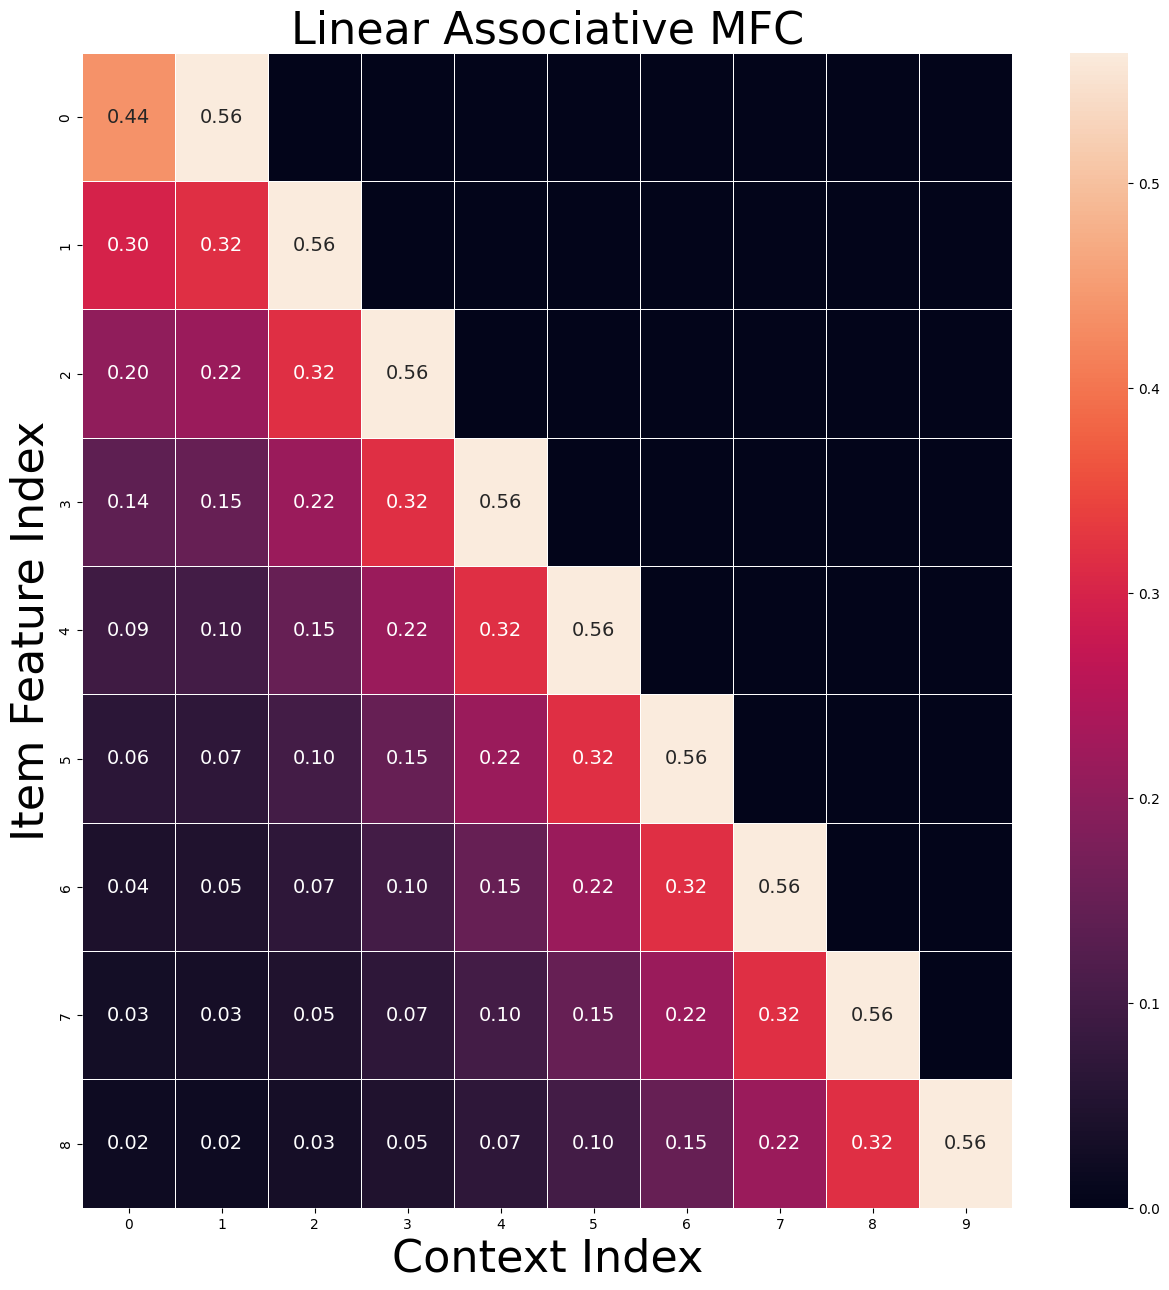

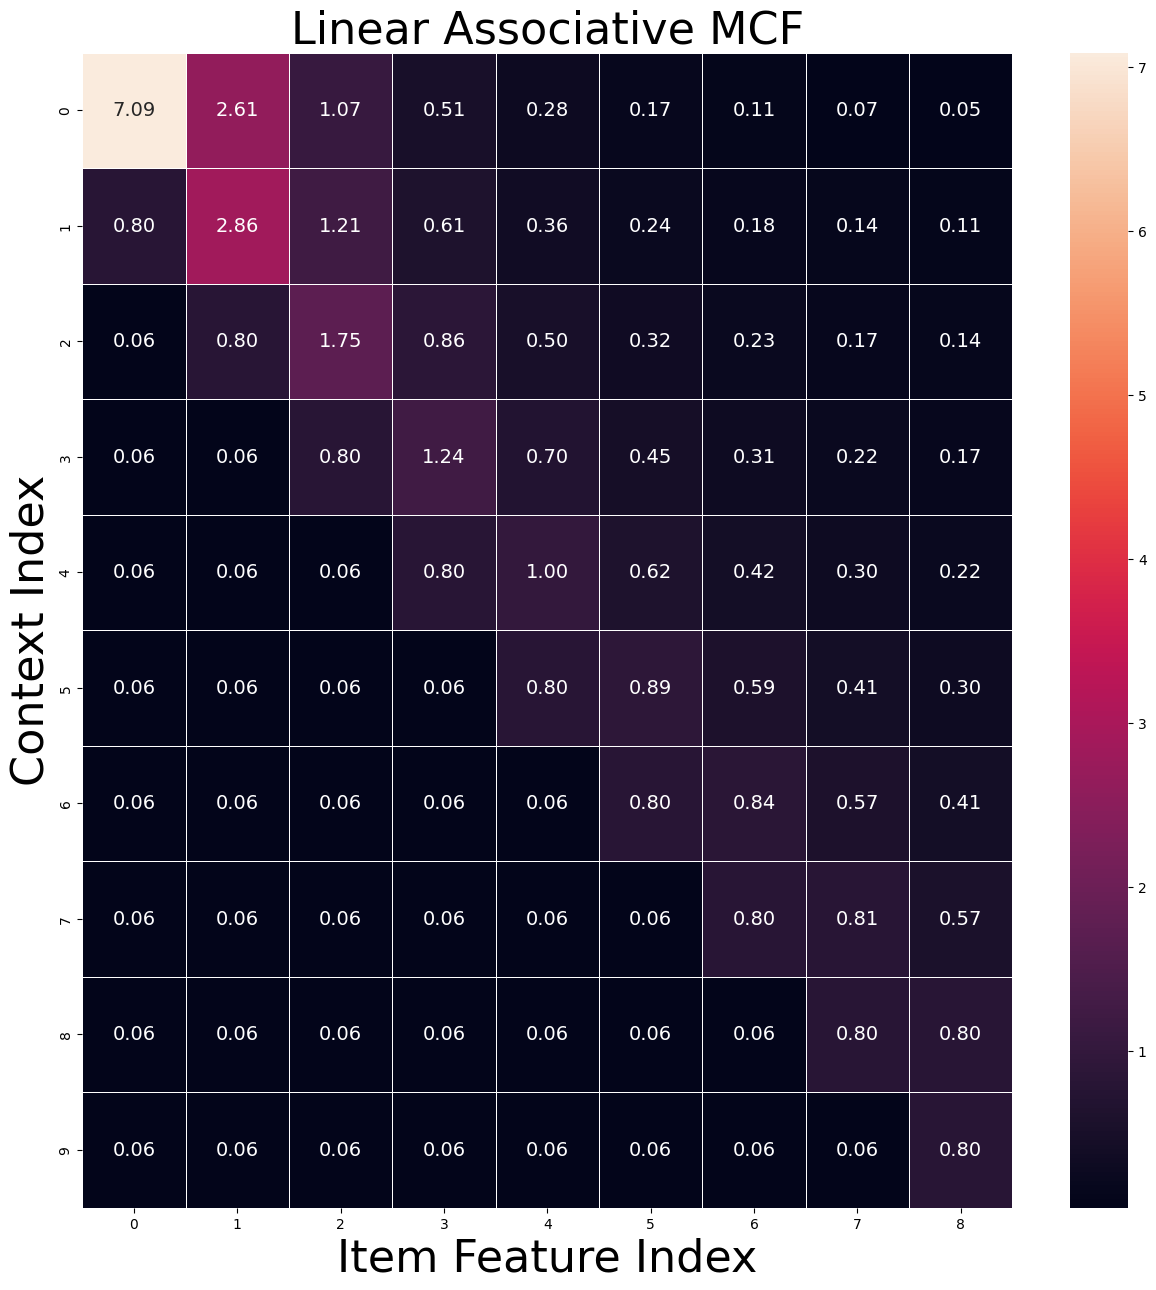

[1 2 3 4 5 6 2 7 8]


In [5]:
# | code-summary: linear memory using the model and a study list with one item repetition (positions 2, 7; item 2)
parameters = base_params

model = BaseCMR(item_count, parameters)
model = lax.fori_loop(0, list_length, lambda i, m: m.experience(present[i]), model)
model = model.start_retrieving()

matrix_heatmap(model.mfc.state, title="Linear Associative MFC")
plt.xlabel("Context Index")
plt.ylabel("Item Feature Index")
plt.show()

matrix_heatmap(model.mcf.state, title="Linear Associative MCF")
plt.xlabel("Item Feature Index")
plt.ylabel("Context Index")
plt.show()
print(present)

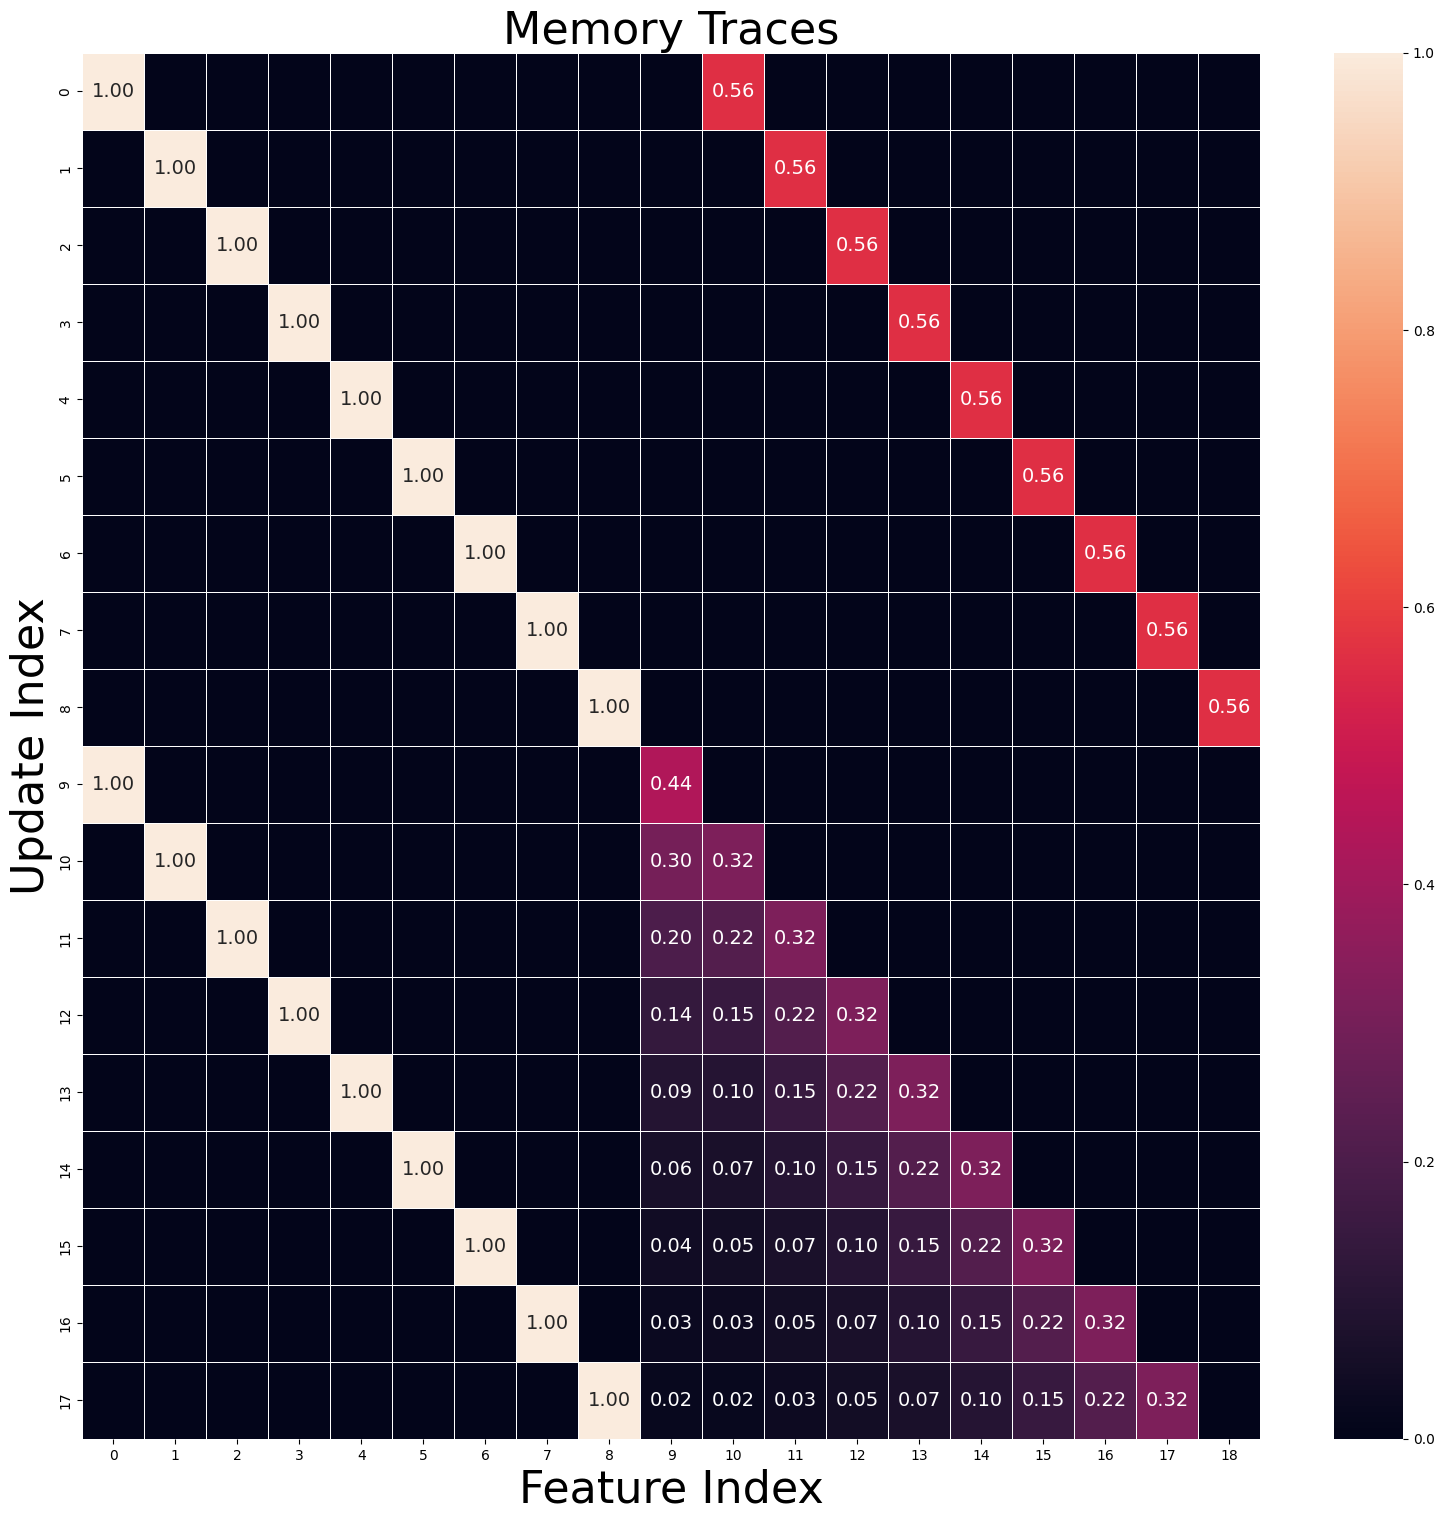

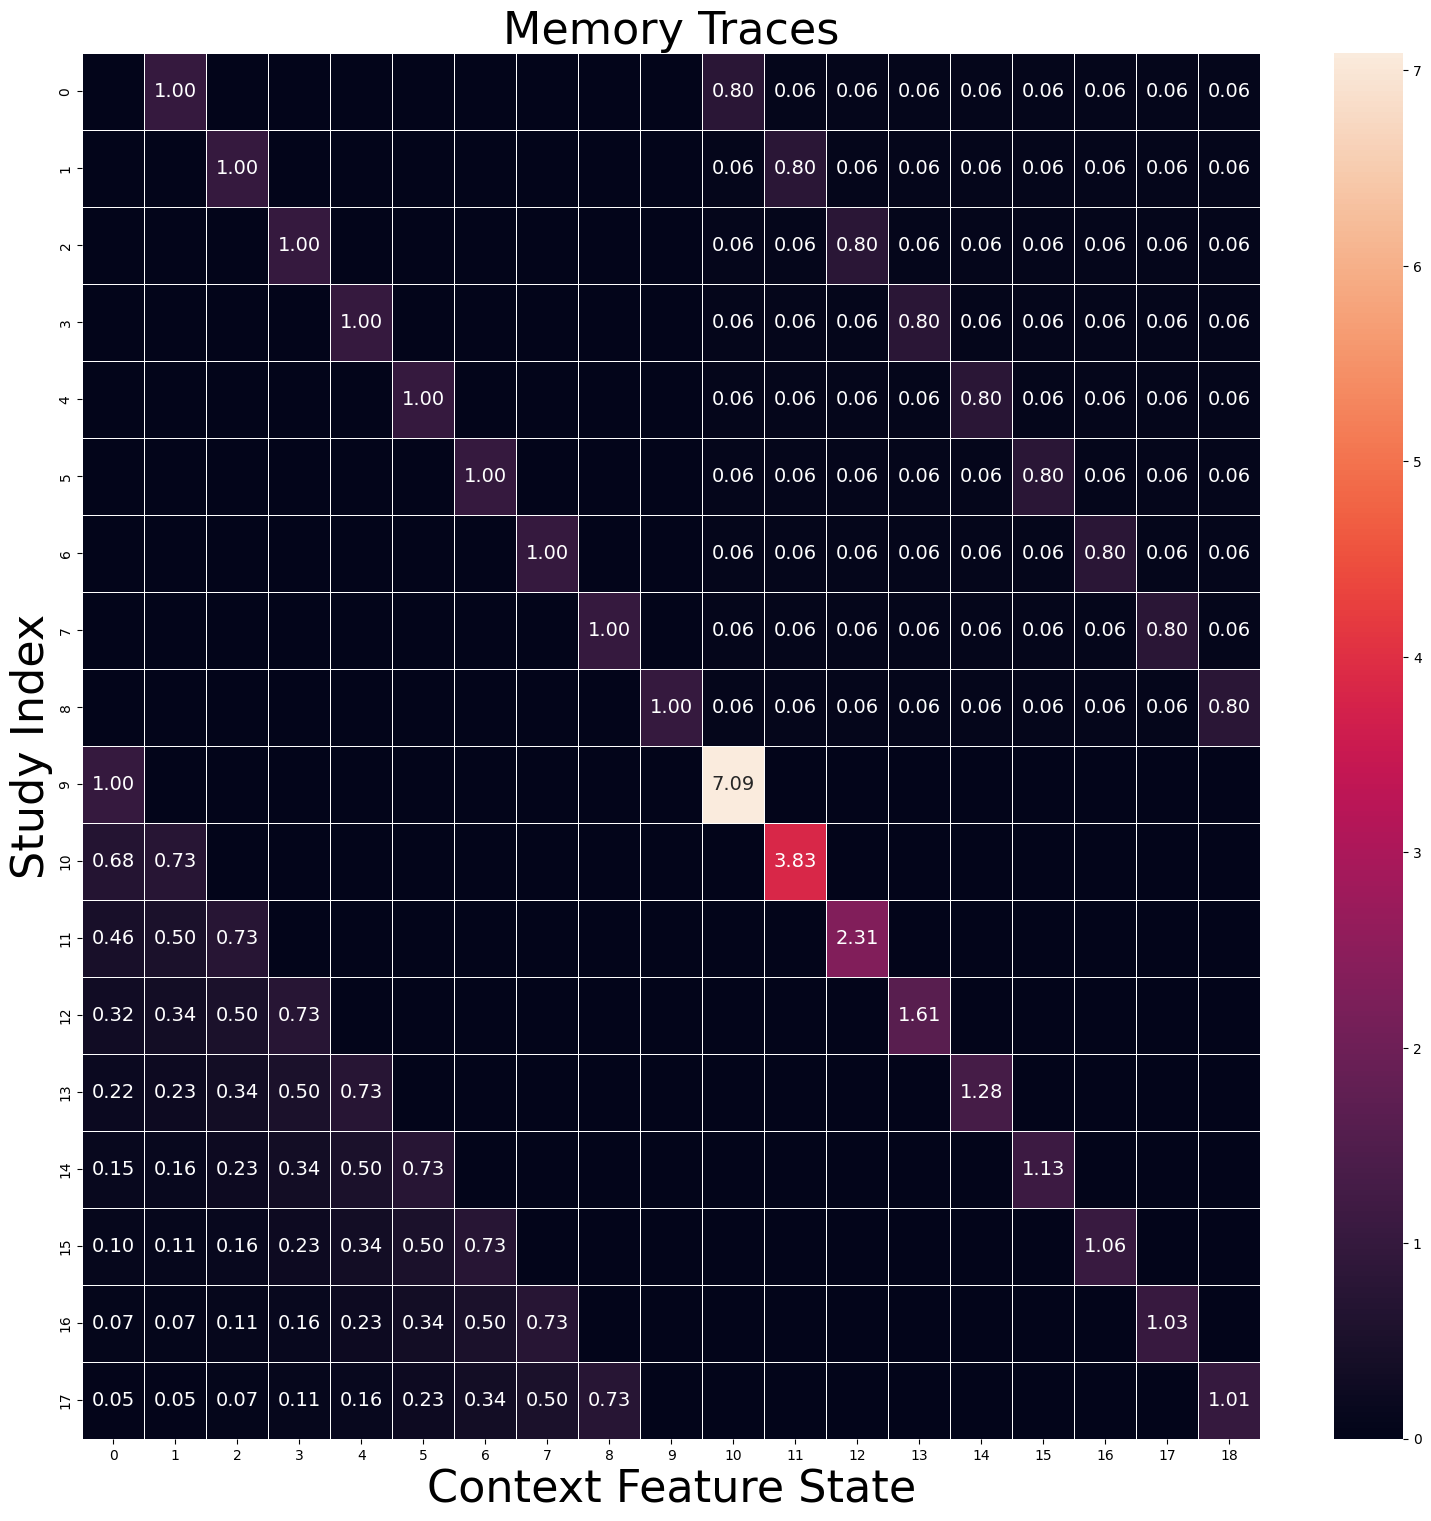

[1 2 3 4 5 6 2 7 8]


In [6]:
# | code-summary: linear memory using the model and a study list with one item repetition (positions 2, 7; item 2)
parameters = base_params

model = InstanceCMR(item_count, parameters)
model = lax.fori_loop(0, list_length, lambda i, m: m.experience(present[i]), model)
model = model.start_retrieving()

instance_memory_heatmap(
    model.mfc.state,
    array_vis_list_length,
    include_inputs=True,
    include_outputs=True,
    include_preexperimental=True,
)
plt.show()

instance_memory_heatmap(
    model.mcf.state,
    list_length,
    include_inputs=True,
    include_outputs=True,
    include_preexperimental=True,
)
plt.ylabel("Study Index")
plt.xlabel("Context Feature State")
plt.savefig("context_states.pdf", bbox_inches="tight")
plt.show()
print(present)

We observe in standard CMR that both presentations of the same item reinstate the same pre-experimental context. This makes it so that a contextual cue that contacts neighbors of one presentation will tend to also contact neighbors of the other presentation, making selective cueing of just one presentation more challenging.

## Cue Manipulation

Question to answer: 
- How are the traces corresponding to each presentation of the same item related in memory?
- Which changes could favor retrieval of first presentation neighbors over second presentation neighbors?

Here we test our predictions about how model memory features identified in the previous section affect the ability to selectively retrieve one presentation of an item over another. We construct retrieval cues based on three different patterns:
- **Item's Associated Context**: The composite context associated with the item in $M^{FC}$.
- **First Presentation Context**: The context associated with the first presentation of the item in $M^{FC}$.
- **Second Presentation Context**: The context associated with the second presentation of the item in $M^{FC}$.
- **Item's Pre-Experimental Context**: The pre-experimental context associated with the item in $M^{FC}$.
- **Average Context**: The average context associated with the item across all presentations in $M^{FC}$.

Pre-Retrieval Model Context State: [0.10491047 0.03395418 0.04980749 0.07306276 0.10717598 0.15721676
 0.23062174 0.33829972 0.49625283 0.7279547 ]
Retrieval Probabilities: [0.01324401 0.14917311 0.1731074  0.04605579 0.04388247 0.05192722
 0.07081043 0.16947307 0.2823264  0.        ]


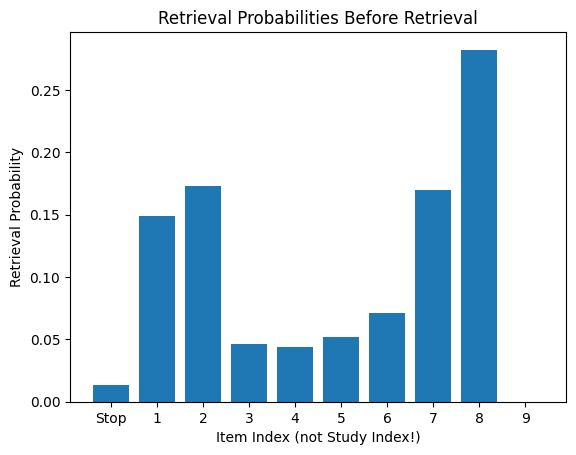

Model Recalls: [0 0 0 0 0 0 0 0 0]
Presented Items: [1 2 3 4 5 6 2 7 8]
List Length: 9
Item Count: 9
Repeater Item Index: 2
Repeater First Encoding Index: 1
Repeater Second Encoding Index: 6


In [7]:
# | code-summary: setup an analysis of recall activations/probabilities in the model as fn of parameter manipulation

model = InstanceCMR(list_length, parameters)
model = lax.fori_loop(0, list_length, lambda i, m: m.experience(present[i]), model)
model = model.start_retrieving()

# simulate retrieval of repeated item
print("Pre-Retrieval Model Context State:", model.context.state)
print("Retrieval Probabilities:", model.outcome_probabilities())
# plot the retrieval probabilities
plt.bar(range(len(model.outcome_probabilities())), model.outcome_probabilities())
plt.xlabel("Item Index (not Study Index!)")
plt.ylabel("Retrieval Probability")
plt.title("Retrieval Probabilities Before Retrieval")
plt.xticks(
    range(len(model.outcome_probabilities())),
    ["Stop"] + [i + 1 for i in range(len(model.outcome_probabilities()) - 1)],  # type: ignore
)
plt.show()
print("Model Recalls:", model.recalls)
print("Presented Items:", present)
print("List Length:", list_length)
print("Item Count:", item_count)
print("Repeater Item Index:", repeater_item_index)
print('Repeater First Encoding Index:', repeater_first_encoding_index)
print("Repeater Second Encoding Index:", repeater_second_encoding_index)

Retrieving Backward Neighbor of Second Presentation 6
Model Context State: [0.11678091 0.09190632 0.13466862 0.19708063 0.28766507 0.41769123
 0.70389575 0.14703935 0.21569246 0.31639984]
Retrieval Probabilities: [0.01498468 0.13800137 0.26915398 0.08315717 0.09315844 0.12321241
 0.         0.14036594 0.13796602 0.        ]


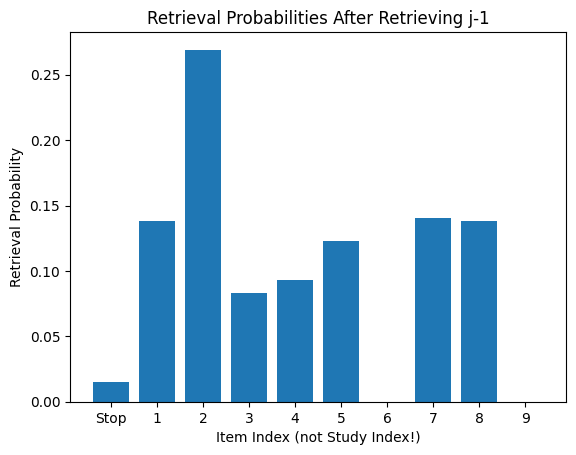

Model Recalls: [6 0 0 0 0 0 0 0 0]
Presented Items: [1 2 3 4 5 6 2 7 8]
List Length: 9
Item Count: 9


In [8]:
print(f"Retrieving Backward Neighbor of Second Presentation {repeater_second_encoding_index}")
model = InstanceCMR(list_length, parameters)
model = lax.fori_loop(0, list_length, lambda i, m: m.experience(present[i]), model)
model = model.start_retrieving()
model = model.retrieve(repeater_second_encoding_index)

print("Model Context State:", model.context.state)
print("Retrieval Probabilities:", model.outcome_probabilities())
# plot the retrieval probabilities after retrieval
plt.bar(range(len(model.outcome_probabilities())), model.outcome_probabilities())
plt.xlabel("Item Index (not Study Index!)")
plt.ylabel("Retrieval Probability")
plt.title("Retrieval Probabilities After Retrieving j-1")
plt.xticks(
    range(len(model.outcome_probabilities())),
    ["Stop"] + [i + 1 for i in range(len(model.outcome_probabilities()) - 1)],  # type: ignore
)
plt.show()
print("Model Recalls:", model.recalls)
print("Presented Items:", present)
print("List Length:", list_length)
print("Item Count:", item_count)

Retrieving Repeater 2
Model Context State: [0.22582506 0.22950509 0.37855586 0.16861133 0.2413074  0.33690336
 0.4679328  0.55571127 0.08921598 0.13087115]
Retrieval Probabilities: [0.01695412 0.30731916 0.         0.19299822 0.12446994 0.11694508
 0.         0.13931237 0.10200109 0.        ]


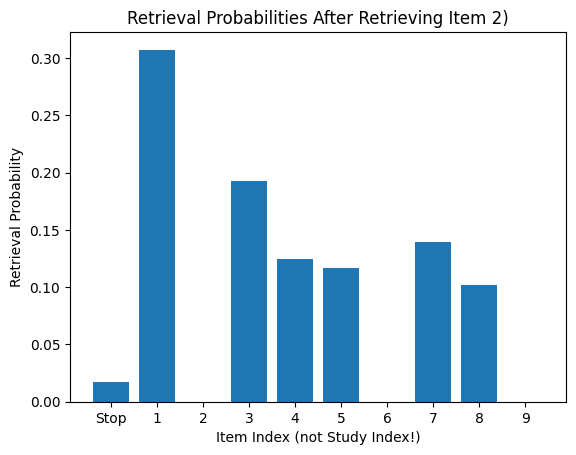

Model Recalls: [6 2 0 0 0 0 0 0 0]
Presented Items: [1 2 3 4 5 6 2 7 8]
List Length: 9
Item Count: 9


In [9]:
print(f"Retrieving Repeater {repeater_item_index}")
model = InstanceCMR(list_length, parameters)
model = lax.fori_loop(0, list_length, lambda i, m: m.experience(present[i]), model)
model = model.start_retrieving()
model = model.retrieve(repeater_second_encoding_index)
model = model.retrieve(repeater_item_index)

print("Model Context State:", model.context.state)
print("Retrieval Probabilities:", model.outcome_probabilities())
# plot the retrieval probabilities after retrieval
plt.bar(range(len(model.outcome_probabilities())), model.outcome_probabilities())
plt.xlabel("Item Index (not Study Index!)")
plt.ylabel("Retrieval Probability")
plt.title(f"Retrieval Probabilities After Retrieving Item {repeater_item_index})")
plt.xticks(
    range(len(model.outcome_probabilities())),
    ["Stop"] + [i + 1 for i in range(len(model.outcome_probabilities()) - 1)],  # type: ignore
)
plt.show()
print("Model Recalls:", model.recalls)
print("Presented Items:", present)
print("List Length:", list_length)
print("Item Count:", item_count)

In [10]:
model.studied == repeater_item_index

Array([False,  True, False, False, False, False,  True, False, False],      dtype=bool)

Current Context:
 [0.22582506 0.22950509 0.37855586 0.16861133 0.2413074  0.33690336
 0.4679328  0.55571127 0.08921598 0.13087115]

Repeater MFC-Associated Context:
 [0.31812048 0.3414137  0.590003   0.09428155 0.1383019  0.20287545
 0.2975986  0.5257305  0.         0.        ]

Combined Encoding Contexts:
 [0.35197133 0.37774318 0.55411255 0.10431395 0.15301844 0.22446321
 0.32926574 0.48300087 0.         0.        ]

First Encoding Context:
 [0.4647263 0.4987542 0.731624  0.        0.        0.        0.
 0.        0.        0.       ]

Second Encoding Context:
 [0.06842115 0.07343104 0.1077162  0.15800922 0.2317842  0.34000492
 0.4987542  0.731624   0.         0.        ]



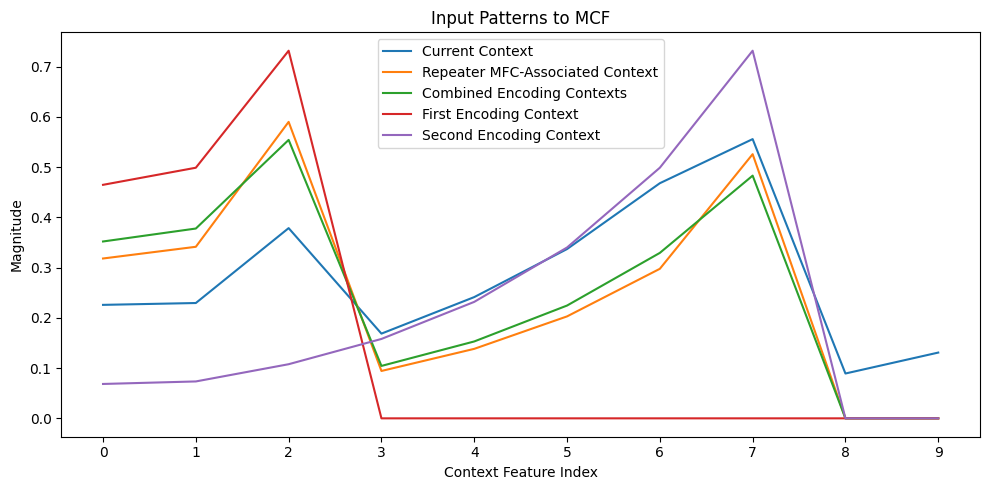

Model Recalls: [6 2 0 0 0 0 0 0 0]
Presented Items: [1 2 3 4 5 6 2 7 8]
List Length: 9
Item Count: 9


In [11]:
#|code-summary: construct probes to MCF: one for the item, one for a combination of both contexts paired with each item, and one for each context associated with each item in the pair, one for current context too

inputs = []
labels = []

# current context given previous retrievals
mcf_in_pattern = model.context.state
inputs.append(mcf_in_pattern)
labels.append("Current Context")

# pass item through MFC to retrieve contextual input (variable behavior depending on model)
mcf_in_pattern = model.mfc.probe(model.studied == repeater_item_index)
mcf_in_pattern = normalize_magnitude(mcf_in_pattern)
inputs.append(mcf_in_pattern)
labels.append("Repeater MFC-Associated Context")

# combination of contexts associated with either encoding of the repeated item
mcf_in_pattern = (
    model.mcf.state[item_count + repeater_first_encoding_index+1][: model.mcf.input_size]
    + model.mcf.state[item_count + repeater_second_encoding_index+1][: model.mcf.input_size]
)
mcf_in_pattern = normalize_magnitude(mcf_in_pattern)
inputs.append(mcf_in_pattern)
labels.append("Combined Encoding Contexts")


# using the context associated with just the first encoding of the repeated item
mcf_in_pattern = model.mcf.state[item_count + repeater_first_encoding_index + 1][
    : model.mcf.input_size
]
mcf_in_pattern = normalize_magnitude(mcf_in_pattern)
inputs.append(mcf_in_pattern)
labels.append("First Encoding Context")

# using the context associated with just the second encoding of the repeated item
mcf_in_pattern = model.mcf.state[item_count + repeater_second_encoding_index + 1][
    : model.mcf.input_size
]
mcf_in_pattern = normalize_magnitude(mcf_in_pattern)
inputs.append(mcf_in_pattern)
labels.append("Second Encoding Context")

# print out the input patterns
for (mcf_in_pattern, label) in zip(inputs, labels):
    print(f"{label}:\n {mcf_in_pattern}\n")

# plot the input patterns
plt.figure(figsize=(10, 5))
for i, mcf_in_pattern in enumerate(inputs):
    plt.plot(mcf_in_pattern, label=labels[i])
plt.title("Input Patterns to MCF")
plt.xlabel("Context Feature Index")
plt.ylabel("Magnitude")

# 1-indexed x-ticks for context features
plt.xticks(range(len(mcf_in_pattern)), [str(i) for i in range(len(mcf_in_pattern))])
plt.legend()
# plt.xlim(0, len(mcf_in_pattern) - 3)
plt.tight_layout()
plt.show()

print("Model Recalls:", model.recalls)
print("Presented Items:", present)
print("List Length:", list_length)
print("Item Count:", item_count)

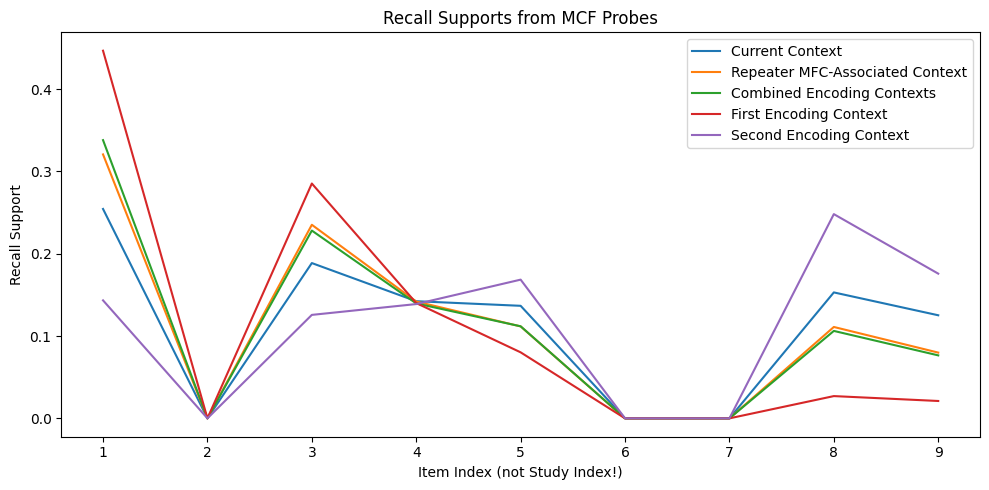

Model Recalls: [6 2 0 0 0 0 0 0 0]
Presented Items: [1 2 3 4 5 6 2 7 8]
List Length: 9
Item Count: 9


In [12]:
#| plot recall supports obtained from each mcf input pattern
 
activations = []

for mcf_in_pattern in inputs:
    activation = model.mcf.probe(mcf_in_pattern) * model.recallable
    activation = activation / activation.sum()
    activations.append(activation)

recall_supports = jnp.array(activations)

plt.figure(figsize=(10, 5))
for i, activation in enumerate(recall_supports):
    plt.plot(activation, label=labels[i])
plt.title("Recall Supports from MCF Probes")
plt.xlabel("Item Index (not Study Index!)")
plt.ylabel("Recall Support")
plt.xticks(
    range(len(activation)),
    [i + 1 for i in range(len(activation))],  # type: ignore
)
plt.legend()
plt.tight_layout()
plt.show()

print("Model Recalls:", model.recalls)
print("Presented Items:", present)
print("List Length:", list_length)
print("Item Count:", item_count)

[1.9277804 0.        1.429597  1.0784277 1.036062  0.        0.
 1.1594021 0.948911 ]
7.5801806
[2.639688   0.         1.9359591  1.1682491  0.91942793 0.
 0.         0.91388535 0.65750295]
8.234713
[2.9085882  0.         1.963068   1.2013901  0.9622441  0.
 0.         0.91398376 0.6582812 ]
8.607555
[3.736584   0.         2.3867714  1.171611   0.6708307  0.
 0.         0.22612213 0.17641507]
8.368335
[0.6691905  0.         0.58677965 0.648191   0.7867252  0.
 0.         1.1583318  0.8207143 ]
4.669933
[[0.25431854 0.         0.1885967  0.14226939 0.13668038 0.
  0.         0.15295178 0.12518317]
 [0.3205562  0.         0.23509735 0.14186884 0.1116527  0.
  0.         0.11097963 0.07984528]
 [0.33791107 0.         0.22806336 0.1395739  0.11179063 0.
  0.         0.10618389 0.07647714]
 [0.44651464 0.         0.28521463 0.14000526 0.08016299 0.
  0.         0.02702116 0.02108126]
 [0.14329767 0.         0.12565055 0.13880092 0.16846606 0.
  0.         0.24804035 0.17574434]]


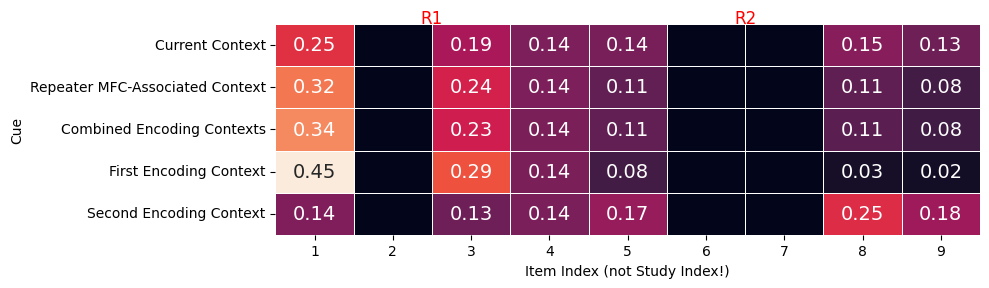

Model Recalls: [6 2 0 0 0 0 0 0 0]
Presented Items: [1 2 3 4 5 6 2 7 8]
List Length: 9
Item Count: 9


In [13]:
#| plot recall supports obtained from each mcf input pattern
 
activations = []

for mcf_in_pattern in inputs:
    activation = model.mcf.probe(mcf_in_pattern) * model.recallable
    print(activation)
    print(activation.sum())
    activation = activation / activation.sum()
    activations.append(activation)

recall_supports = jnp.array(activations)

print(recall_supports)
matrix_heatmap(recall_supports, figsize=(10, 3))
plt.xlabel("Item Index (not Study Index!)", fontsize=10)
plt.ylabel("Cue", fontsize=10)
plt.yticks([.5, 1.5, 2.5, 3.5, 4.5] , labels)

# rotate yticks to be horizontal
plt.yticks(rotation=0)

# use 1-indexed x-ticks for item indices, center at .5
plt.xticks([i + 0.5 for i in range(len(recall_supports[0]))], [str(i + 1) for i in range(len(recall_supports[0]))])

# put red box around text of the xticks succeeding first and second repeater encoding indices
plt.text(repeater_first_encoding_index + 1, -.35, "R1", ha="center", va="top", color="red", fontsize=12)
plt.text(repeater_second_encoding_index, -.35, "R2", ha="center", va="top", color="red", fontsize=12)

# remove the colorbar
axis = plt.gca()
# remove the colorbar
cax = axis.collections[0].colorbar
cax.remove()
plt.tight_layout()
plt.show()

print("Model Recalls:", model.recalls)
print("Presented Items:", present)
print("List Length:", list_length)
print("Item Count:", item_count)
# plt.savefig("trace_supports.pdf", bbox_inches="tight")

In [14]:
jnp.zeros_like(model.studied).at[jnp.argmax(model.studied == repeater_item_index)].set(1)

Array([0, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [15]:
model.studied == repeater_item_index

Array([False,  True, False, False, False, False,  True, False, False],      dtype=bool)

In [16]:
model.mfc.probe(jnp.zeros_like(model.studied).at[jnp.argmax(model.studied == repeater_item_index)].set(1))

Array([0.29736856, 0.3191423 , 0.5637891 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ],      dtype=float32)

In [17]:
model.positions

Array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)